#Import Libraries

In [59]:
#Libraries for general purpose
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import numpy as np
import re
import string

# Support Vector Machine (SVM)
from sklearn.svm import SVC
# Naive Bayes (NB)
from sklearn.naive_bayes import MultinomialNB
# Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier

# Model Create
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocessing Word
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# To save and read model
import pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Import Dataset

In [84]:
# Clone dataset dari github
!git clone https://github.com/Theofilusarifin/cyberbullying_resources.git

git-lfs/2.3.4 (GitHub; linux amd64; go 1.8.3)
Sorry, no usage text found for "git-lfs"
fatal: destination path 'cyberbullying_resources' already exists and is not an empty directory.


In [58]:
df = pd.read_csv('cyberbullying_resources/cyberbullying_tweets.csv')

#Functions

In [4]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

#Exploratory Data Analysis

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

As we can see data is distributted equally

In [7]:
# length of dataset
len(df)

47692

#Preprocessing

In [8]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

There is no null value in data so dropNa is no needed

In [9]:
# storing the data in lists
tweet, type = list(df['tweet_text']), list(df['cyberbullying_type'])

In [10]:
# Get each sentiment
sentiments = list(set(type))
sentiments

['religion',
 'age',
 'other_cyberbullying',
 'ethnicity',
 'gender',
 'not_cyberbullying']

In [11]:
# Encoding the labels
labelencoder = LabelEncoder()
df['cyberbullying_type_encoded'] = labelencoder.fit_transform(df['cyberbullying_type'])

In [12]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
dtype: int64

In [13]:
# converting tweet text to lower case
df['tweet_text'] = df['tweet_text'].str.lower()
df.tail()

,tweet_text,cyberbullying_type,cyberbullying_type_encoded
47687,"black ppl aren't expected to do anything, depe...",ethnicity,1
47688,turner did not withhold his disappointment. tu...,ethnicity,1
47689,i swear to god. this dumb nigger bitch. i have...,ethnicity,1
47690,yea fuck you rt @therealexel: if youre a nigge...,ethnicity,1
47691,bro. u gotta chill rt @chillshrammy: dog fuck ...,ethnicity,1


In [14]:
# stopwords list that needs to be excluded from the data
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [15]:
# removing stopwoords from the tweet text
STOPWORDS = set(stopwordlist)

def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweet_text'] = df['tweet_text'].apply(lambda text: clean_stopwords(text))

In [16]:
# cleaning and removing punctuations
english_puctuations = string.punctuation

def clean_puctuations(text):
    translator = str.maketrans('','', english_puctuations)
    return text.translate(translator)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_puctuations(x))

In [17]:
# cleaning and removing repeating characters
def clean_repeating_characters(text):
    return re.sub(r'(.)1+', r'1', text)

df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_repeating_characters(x))

In [18]:
# cleaning and removing URLs
def clean_URLs(text):
    return re.sub(r"((www.[^s]+)|(http\S+))","",text)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_URLs(x))

In [19]:
# cleaning and removing numeric data
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)
    
df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_numeric(x))

In [20]:
# Tokenization of tweet text
tokenizer = RegexpTokenizer('\w+')
df['tweet_text'] = df['tweet_text'].apply(tokenizer.tokenize)

In [21]:
# stemming
st = nltk.PorterStemmer()

def text_stemming(text):
    text = [st.stem(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_stemming(x))

In [22]:
# lemmatization
lm = nltk.WordNetLemmatizer()

def text_lemmatization(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_lemmatization(x))

In [23]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
dtype: int64

#Word Cloud

In [24]:
# plotting word cloud excluding other_cybberbullying and not_cyberbullying
new_df = df
new_df = new_df[new_df['cyberbullying_type'] != 'other_cyberbullying']
new_df = new_df[new_df['cyberbullying_type'] != 'not_cyberbullying']
new_df = new_df['tweet_text'].apply(lambda x: " ".join(x))

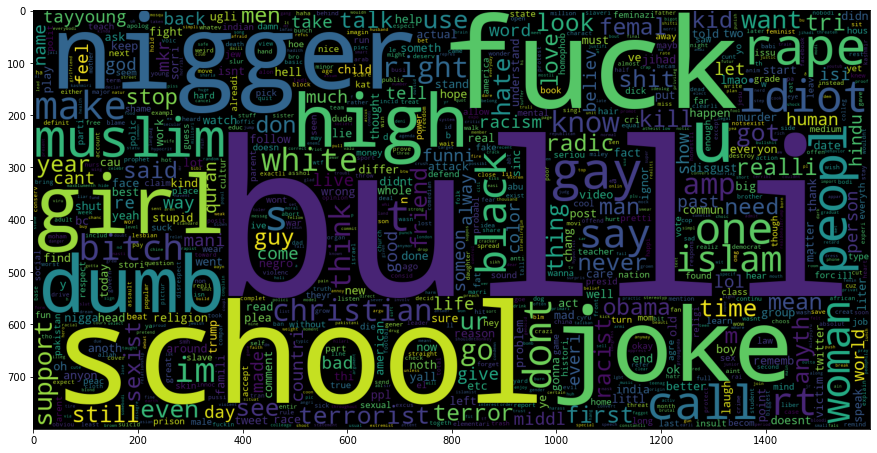

In [25]:
plt.figure(figsize= (15,15))
wc = WordCloud(max_words=1000, width= 1600, height= 800, 
                collocations= False).generate(' '.join(new_df))
plt.imshow(wc)

In [26]:
# Creating a word cloud
# We will have to exclude the tweets which are not_cyberbullying for this task 
data = pd.read_csv('cyberbullying_resources/cyberbullying_tweets.csv')
data = data[data['cyberbullying_type'] != "not_cyberbullying"]
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

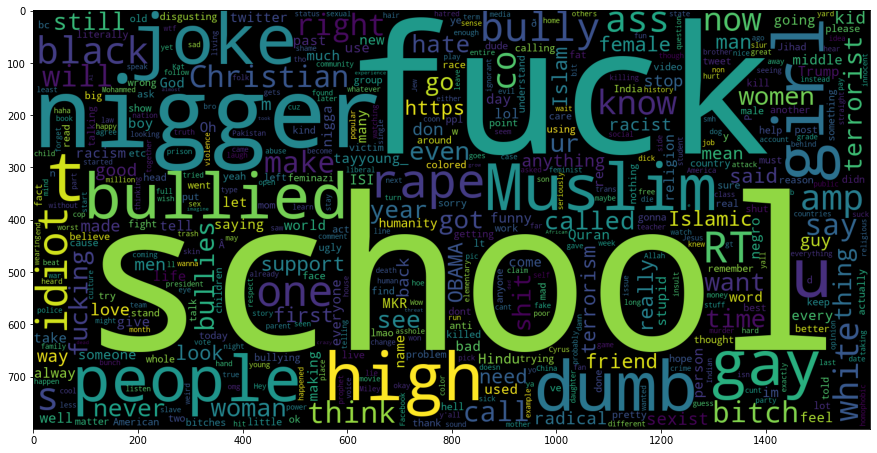

In [27]:
# word cloud

plotting_data = data['tweet_text']
plt.figure(figsize= (15,15))
wc = WordCloud(max_words=500, width= 1600, height= 800, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [28]:
# excluding the other_cyberbullying values and plotting again
data_2 = data[data['cyberbullying_type'] != "not_cyberbullying"]
data_2 = data[data['cyberbullying_type'] != "other_cyberbullying"]
data_2['cyberbullying_type'].value_counts()

religion     7998
age          7992
gender       7973
ethnicity    7961
Name: cyberbullying_type, dtype: int64

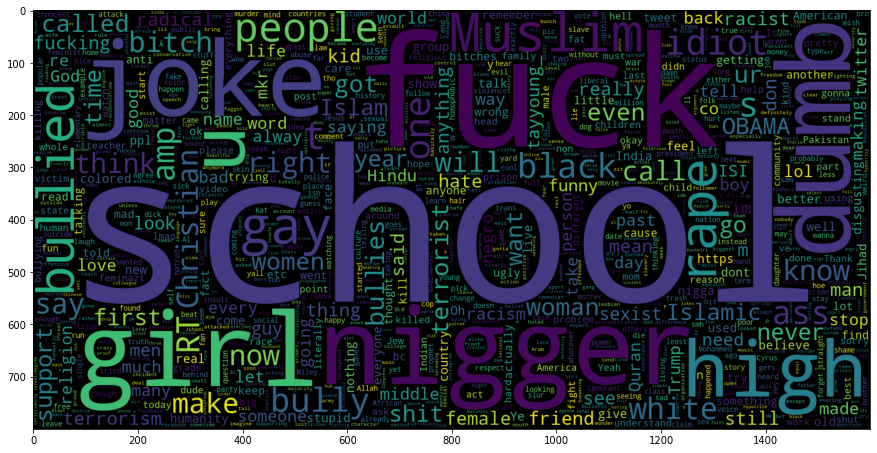

In [29]:
plotting_data = data_2['tweet_text']
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width= 1600, height= 800, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

#Split Data

In [30]:
df['tweet_text'] = df['tweet_text'].apply(lambda x : " ".join(x))

In [31]:
# Splitting the data into train and test
X, y = df['tweet_text'], df['cyberbullying_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 41)

In [32]:
# Transforming the data using TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features= 500000)
vectoriser.fit(X_train)
print("No. of feature words: ",len(vectoriser.get_feature_names()))

No. of feature words:  312805


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
# transforming the data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

#Model

##Naive Bayes (NB)

In [34]:
# NB Classifier
nb_clf = MultinomialNB().fit(X_train, y_train)

In [35]:
y_nb_pred  = nb_clf.predict(X_test)

##Random Forest

In [36]:
# RF Classifier
rf_clf = RandomForestClassifier().fit(X_train, y_train)

In [37]:
y_rf_pred  = rf_clf.predict(X_test)

##Support Vector Machine (SVM)

In [38]:
# SVM Classifier
svm_clf = SVC(kernel= 'linear', C = 1).fit(X_train, y_train)

In [39]:
y_svm_pred  = svm_clf.predict(X_test)

# Model Evaluation

## Confussion Matrix

### Naive Bayes

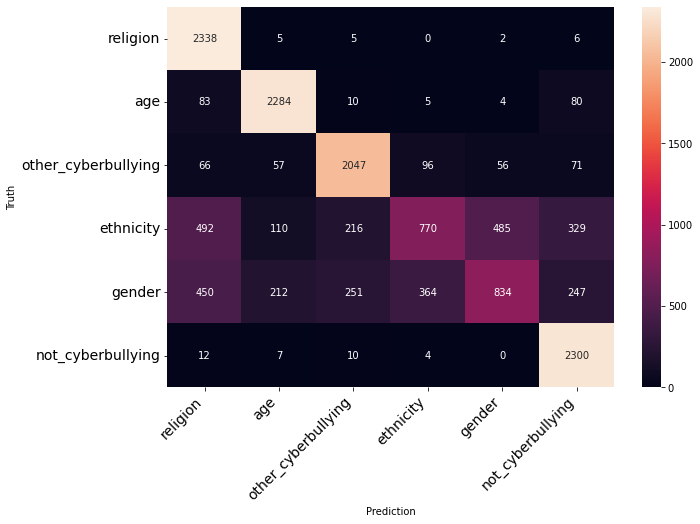

In [40]:
# Confussion Matrix Naive Bayes
cm = confusion_matrix(y_test,y_nb_pred)
print_confusion_matrix(cm,sentiments)

### Random Forest

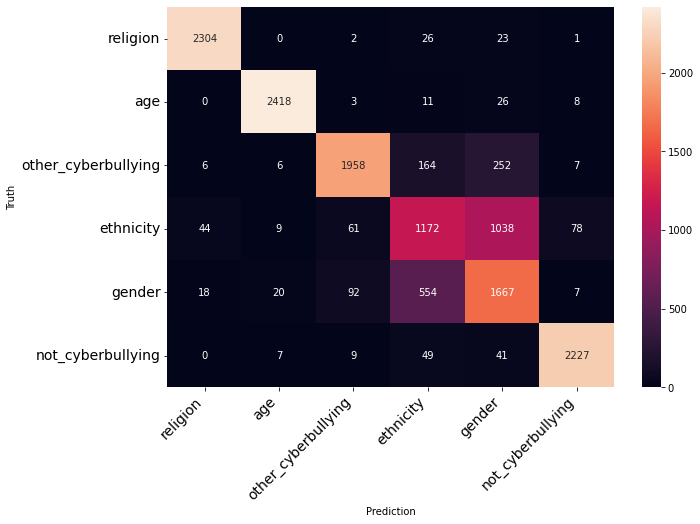

In [41]:
# Confussion Matrix Random Forest
cm = confusion_matrix(y_test,y_rf_pred)
print_confusion_matrix(cm,sentiments)

### SVM

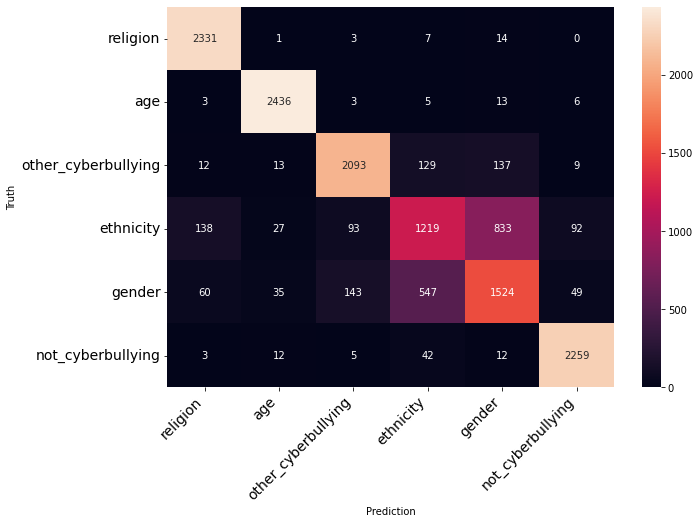

In [91]:
# Confussion Matrix SVM
cm = confusion_matrix(y_test,y_svm_pred)
print_confusion_matrix(cm,sentiments)

## Classification Report

In [92]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, y_nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
                      precision    recall  f1-score   support

           religion       0.68      0.99      0.81      2356
                age       0.85      0.93      0.89      2466
other_cyberbullying       0.81      0.86      0.83      2393
          ethnicity       0.62      0.32      0.42      2402
             gender       0.60      0.35      0.45      2358
  not_cyberbullying       0.76      0.99      0.86      2333

           accuracy                           0.74     14308
          macro avg       0.72      0.74      0.71     14308
       weighted avg       0.72      0.74      0.71     14308



In [93]:
print('Classification Report for Random Forest:\n',classification_report(y_test, y_rf_pred, target_names=sentiments))

Classification Report for Random Forest:
                      precision    recall  f1-score   support

           religion       0.97      0.98      0.97      2356
                age       0.98      0.98      0.98      2466
other_cyberbullying       0.92      0.82      0.87      2393
          ethnicity       0.59      0.49      0.54      2402
             gender       0.55      0.71      0.62      2358
  not_cyberbullying       0.96      0.95      0.96      2333

           accuracy                           0.82     14308
          macro avg       0.83      0.82      0.82     14308
       weighted avg       0.83      0.82      0.82     14308



In [94]:
print('Classification Report for Support Vector Machine:\n',classification_report(y_test, y_svm_pred, target_names=sentiments))

Classification Report for Support Vector Machine:
                      precision    recall  f1-score   support

           religion       0.92      0.99      0.95      2356
                age       0.97      0.99      0.98      2466
other_cyberbullying       0.89      0.87      0.88      2393
          ethnicity       0.63      0.51      0.56      2402
             gender       0.60      0.65      0.62      2358
  not_cyberbullying       0.94      0.97      0.95      2333

           accuracy                           0.83     14308
          macro avg       0.82      0.83      0.82     14308
       weighted avg       0.82      0.83      0.82     14308



## Sklearn Metrics Accuracy 

In [46]:
print("Accuracy Score (Naive Bayes): ", accuracy_score(y_test, y_nb_pred))
print("Accuracy Score (Random Forest): ", accuracy_score(y_test, y_rf_pred))
print("Accuracy Score (Support Vector Machine): ", accuracy_score(y_test, y_svm_pred))

Accuracy Score (Naive Bayes):  0.7389572267263069
Accuracy Score (Random Forest):  0.8209393346379648
Accuracy Score (Support Vector Machine):  0.8290466871680179


## Cross Validation Score

In [47]:
NB_cv_score = cross_val_score(nb_clf,X_train, y_train, cv=3)
RF_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=3)
SVM_cv_score = cross_val_score(svm_clf,X_train, y_train, cv=3)

print('Cross validation score (Naive Bayes):', NB_cv_score.mean())
print('Cross validation score (Random Forest):', RF_cv_score.mean())
print('Cross validation score (Support Vector Machine):', SVM_cv_score.mean())

Cross validation score (Naive Bayes): 0.7459561466570812
Cross validation score (Random Forest): 0.8209920920201293
Cross validation score (Support Vector Machine): 0.8218008626887131


#Save Model

In [48]:
# dumping the model
pickle.dump(nb_clf, open('nb_model.bin', 'wb'))
pickle.dump(rf_clf, open('rf_model.bin', 'wb'))
pickle.dump(svm_clf, open('svm_model.bin', 'wb'))

# Load Model

In [86]:
# Upload model first then execute this code
nb_clf = pickle.load(open("nb_model.bin", "rb"))
rf_clf = pickle.load(open("rf_model.bin", "rb"))
svm_clf = pickle.load(open("svm_model.bin", "rb"))

#Predicting Output

In [87]:
example = np.zeros(100)
example = ["Girl bully’s as well. I’ve 2 sons that were bullied in Jr High. Both were bullied by girls. My older was bullied because he had 4ft long brown hair and a baby face. Younger was bullied cuz he hung around the nerd crowd and was an easy target. I know what u mean though! Peace",]
example = vectoriser.transform(example)
example

<1x312805 sparse matrix of type '<class 'numpy.float64'>'
	with 47 stored elements in Compressed Sparse Row format>

In [88]:
nb_clf.predict(example)

array([0])

In [89]:
rf_clf.predict(example)

array([0])

In [90]:
svm_clf.predict(example)

array([0])